# Zero-shot learning experiments: Latent embedding algorithm implementation

In [ ]:
import pandas as pd
import sys

sys.path.append("../../")
sys.path.append("../../../")
from tasks.data_loader.src.utils import *

In [ ]:
data_excel = pd.read_excel("../input/WRI_Policy_Tags.xlsx", engine="openpyxl", sheet_name=None)

In [ ]:
all_labeled_sentences = country_labeled_sentences(data_excel)

In [ ]:
mexico_sents = sentences_from_model_output(all_labeled_sentences['Mexico'])
mexico_labels = labels_from_model_output(all_labeled_sentences['Mexico'])

#### Step 1. Take the top K most frequent words V in the vocabulary of a word2vec model

In [10]:
import spacy
from collections import Counter

In [11]:
es_nlp = spacy.load('es_core_news_md')

In [12]:
sents_as_str = ". ".join(mexico_sents)

In [13]:
doc = es_nlp(sents_as_str)

In [14]:
# all tokens that arent stop words or punctuations
words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 3]

In [15]:
# 20 most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(20)

In [16]:
top_20_words = list(list(zip(*common_words))[0])

In [17]:
top_20_words

['forestales',
 'forestal',
 'apoyos',
 'manejo',
 'servicios',
 'recursos',
 'programa',
 'desarrollo',
 'ambientales',
 'apoyo',
 'económicos',
 'plantaciones',
 'sustentable',
 'conservación',
 'derecho',
 'promover',
 'actividades',
 'producción',
 'impulsar',
 'incentivos']

#### Step 2. Obtain embeddings for each word using word2vec, $\Phi_{word}(V)$

In [18]:
word2vec_embeddings = []

for word in top_20_words:
    doc = es_nlp(word)
    vector = doc.vector
    word2vec_embeddings.append(vector.reshape(1, 300))

In [19]:
word2vec_embeddings[5].shape

(1, 300)

#### Step 3. Obtain embeddings for each word using S-BERT, $\Phi_{sent}(V)$

In [20]:
from sentence_transformers import SentenceTransformer

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [21]:
model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [22]:
sbert_embeddings = []

for word in top_20_words:
    vector = model.encode([word], convert_to_numpy=True)
    sbert_embeddings.append(vector)

In [23]:
sbert_embeddings[5].shape

(1, 768)

#### Step 4. Learn a least-squares linear projection matrix Z with L2 regularization from $\Phi_{sent}(V)$ to $\Phi_{word}(V)$

In [24]:
import numpy as np

In [25]:
stacked_sbert = np.vstack(sbert_embeddings)
stacked_word2vec = np.vstack(word2vec_embeddings)

In [26]:
stacked_sbert.shape, stacked_word2vec.shape

((20, 768), (20, 300))

In [27]:
# Help from: https://stackoverflow.com/questions/27476933/numpy-linear-regression-with-regularization and https://www.kdnuggets.com/2016/11/linear-regression-least-squares-matrix-multiplication-concise-technical-overview.html
# Multiple Linear Regression with OLS parameter estimation with L2 regularization term
lamda = 0.01  # lambda = 0 is equivalent to OLS estimation without regularization
Z = np.linalg.inv(stacked_sbert.T.dot(stacked_sbert) + lamda*np.eye(stacked_sbert.shape[1])).dot(stacked_sbert.T).dot(stacked_word2vec)

In [28]:
Z, Z.shape

(array([[-0.05296201,  0.05583028,  0.05234827, ..., -0.04079495,
          0.04818742, -0.04946214],
        [-0.04508072,  0.04923975,  0.04925937, ...,  0.02819155,
         -0.00223869,  0.01609013],
        [ 0.03526131, -0.0139571 ,  0.02116227, ...,  0.01315127,
         -0.04021973,  0.00149297],
        ...,
        [-0.02402237,  0.01069963, -0.01340641, ..., -0.01896711,
          0.02472438,  0.00564341],
        [-0.01575286, -0.03905317, -0.04087726, ..., -0.01780724,
         -0.02433198,  0.00514585],
        [ 0.02127699, -0.02751969, -0.02669438, ...,  0.00879955,
          0.00394906,  0.0195331 ]]), (768, 300))

#### Step 5. Use $Z$ in our classification as an additional transformation to S-BERT embeddings

$$ \hat{c} = arg\,min\,cos(\Phi_{sent}(x)Z, \Phi_{sent}(c)Z)$$

In [29]:
import torch
from torch.nn import functional as F

In [30]:
sentence = 'Quien sera el presidente en 2020?'
labels = ['negocios', 'cultura', 'politica']

In [31]:
sentence_rep = torch.from_numpy(np.matmul(model.encode(sentence), Z)).reshape(1,300)
label_reps = torch.from_numpy(np.matmul(model.encode(labels), Z))

In [32]:
sentence_rep.shape, label_reps.shape

(torch.Size([1, 300]), torch.Size([3, 300]))

In [33]:
similarities = F.cosine_similarity(sentence_rep, label_reps)
closest = similarities.argsort(descending=True)
for ind in closest:
    print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')

label: cultura 	 similarity: 0.18015918187601748
label: politica 	 similarity: -0.05529046115675037
label: negocios 	 similarity: -0.13342647902291316


In [34]:
print(closest)

tensor([1, 2, 0])


#### Step 6. Time to play on our data!

In [36]:
from tqdm import tqdm
from tasks.evaluate_model.src.model_evaluator import *

In [37]:
sbert_model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [ ]:
def classify_sentence(sentence, labels, model, Z):
    sentence_rep = encode_sentence(sentence, model, Z)
    label_reps = encode_labels(labels, model, Z)

    similarities = F.cosine_similarity(sentence_rep, label_reps)
    closest = similarities.argsort(descending=True)

    top_index = closest[0]
    return labels[top_index], similarities[top_index]

In [38]:
model_preds, model_scores = [], []

for mexico_sent in tqdm(mexico_sents):
    pred, score = classify_sentence(mexico_sent, label_names, sbert_model, Z)
    model_preds.append(pred)
    model_scores.append(score)

100%|██████████| 211/211 [01:28<00:00,  2.39it/s]


In [39]:
evaluator = ModelEvaluator(label_names)

In [40]:
num_multi_labels = labels2numeric(mexico_labels, label_names)
num_multi_preds = labels2numeric(model_preds, label_names)

In [41]:
num_multi_labels[:10], num_multi_preds[:10]

([6, 2, 4, 6, 7, 7, 4, 2, 6, 6], [0, 0, 4, 6, 0, 4, 0, 0, 5, 6])

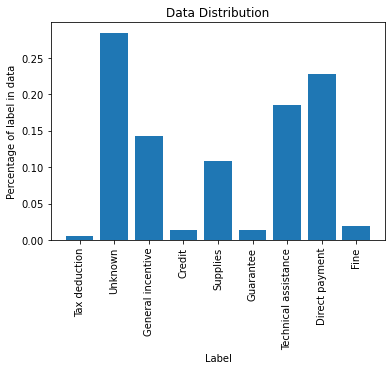

Label counts:
{'Tax deduction': 0.004739336492890996, 'Unknown': 0.2843601895734597, 'General incentive': 0.14218009478672985, 'Credit': 0.014218009478672985, 'Supplies': 0.10900473933649289, 'Guarantee': 0.014218009478672985, 'Technical assistance': 0.1848341232227488, 'Direct payment': 0.22748815165876776, 'Fine': 0.018957345971563982}


In [42]:
plot_data_distribution(num_multi_labels, label_names)

/home/davids/miniconda3/envs/wri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stored confusion matrix: ../output/multi_class_test_cm.png


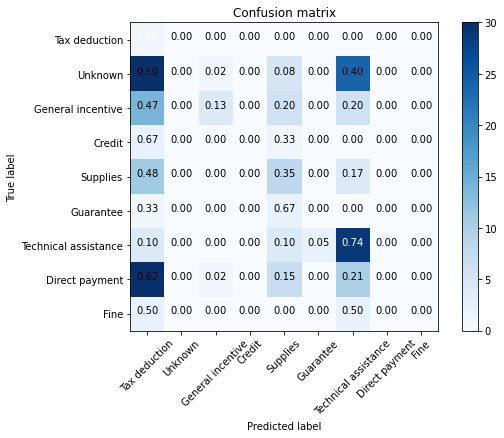

Stored results: ../output/multi_class_test_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Tax deduction,0.01,1,0.55,0.02
Unknown,0,0,1,0
General incentive,0.67,0.13,0.99,0.22
Credit,0,0,1,0
Supplies,0.24,0.35,0.87,0.29
Guarantee,0,0,0.99,0
-----,-----,-----,-----,-----
Technical assistance,0.39,0.74,0.73,0.51
Direct payment,0,0,1,0
Fine,0,0,1,0


In [43]:
evaluator.evaluate(num_multi_labels, num_multi_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="multi_class_test")

Stored Precision-Recall Curve: multi_class_test_prc.png


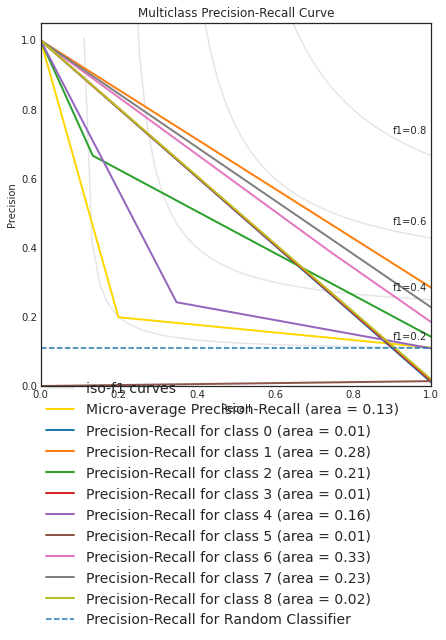

In [44]:
evaluator.plot_precision_recall_curve(num_multi_labels, num_multi_preds, bin_class=False, all_classes=True, store=True, exp_name="multi_class_test")